# Preprocessing 2: Dimensionality reduction on Finance Data

Many learners benefit from a lower dimensionality input dataset. We can add a dimensionality reduction step into our pipeline to achieve this and we will examine PCA (linear dimensionality reduction) and autoencoders (non-linear dimensionality reduction) to see this. However, real finance data has the problem of a large number of catagorical features, such as country or sector. We will see how dimensionality reduction works in the context of a real finance dataset...

In this section we will cover ...

1) Categorical data in finance

2) One hot encodings... 60 Countries in one column? SPlit into 60 columns with ${{1,0}}$ dummy variables. 

3) PCA: We see how to reduce the dimensionality of one hot encoded features

4) Auto-encoders

5) Autoencoder, PCA, full data-set Shoot out...



In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Catagorical Data in Finance


### Exploring the sector and country columns
Let us look at how many unique sectors and countries are in the data.

In [4]:
X = pd.read_csv("X.csv")
X.head()

,NAME,TICKER,SECTOR,COUNTRY,YEAR,AVERAGE RETURN,Beta_DnSide_24m 12 months prior,Beta_DnSide_24m 24 months prior,Beta_DnSide_24m 36 months prior,Diag DebtToEquity 12 months prior,...,EPS 36 months prior,GroupRank_Diag FreeCashFlowpers 12 months prior,GroupRank_Diag FreeCashFlowpers 24 months prior,GroupRank_Diag FreeCashFlowpers 36 months prior,GroupRank_NPL_Loans_egSector 12 months prior,GroupRank_NPL_Loans_egSector 24 months prior,GroupRank_NPL_Loans_egSector 36 months prior,Mkt_Beta_2yrs 12 months prior,Mkt_Beta_2yrs 24 months prior,Mkt_Beta_2yrs 36 months prior
0,Antofagasta plc,8,Materials,United Kingdom,2019,0.250570,0.466629,0.613881,0.605679,0.000323,...,0.563397,0.716,0.473,0.115,0.0,0.0,0.0,0.733146,0.179791,0.266553
1,Ashtead Group plc,11,Industrials,United Kingdom,2019,0.516823,0.520017,0.599024,0.582105,0.000942,...,0.563424,0.603,0.521,0.105,0.0,0.0,0.0,0.749883,0.180655,0.265154
2,Barratt Developments PLC,16,Consumer Discretionary,United Kingdom,2019,0.811012,0.449442,0.504130,0.479913,0.000225,...,0.563414,0.413,0.386,0.547,0.0,0.0,0.0,0.728778,0.180987,0.258411
3,Bellway p.l.c.,17,Consumer Discretionary,United Kingdom,2019,0.631597,0.460925,0.492347,0.491910,0.000125,...,0.563498,0.000,0.000,0.000,0.0,0.0,0.0,0.728606,0.181924,0.260856
4,Balfour Beatty plc,18,Industrials,United Kingdom,2019,0.152388,0.447137,0.538631,0.540481,0.000915,...,0.563386,0.000,0.000,0.000,0.0,0.0,0.0,0.724920,0.179470,0.257796


In [5]:
nsectors = len(pd.unique(X['SECTOR']))     # number of unique sectors
ncountries = len(pd.unique(X['COUNTRY']))  # number of unique countries

print ("There are %i unique sectors in the data, and %i unique countries in the data." % (nsectors, ncountries))

There are 11 unique sectors in the data, and 60 unique countries in the data.


So there are a lot more countries than there are sectors. Now let us look at the frequency distributions of the countries and sectors columns. Recall that from stacking the data during preprocessing a company can appear multiple times in ```X```. We therefore have to take extra care to ensure that each company in only counted once when we calculate the frequenct distributions.

In [6]:
# extract a Series containing the index where each company appears first in X
unique_companies = X['TICKER'].drop_duplicates(keep = 'first')

# extract the set of unique companies from X
X_unique = X.loc[unique_companies.index]

# remove the columns that we are not interested in at the moment
X_unique = X_unique[["NAME", "COUNTRY", "SECTOR"]]

X_unique = X_unique.set_index("NAME")

Now that we have the set of unique companies, we can look at the frequency distributions in the ```COUNTRY``` and ```SECTOR``` columns.

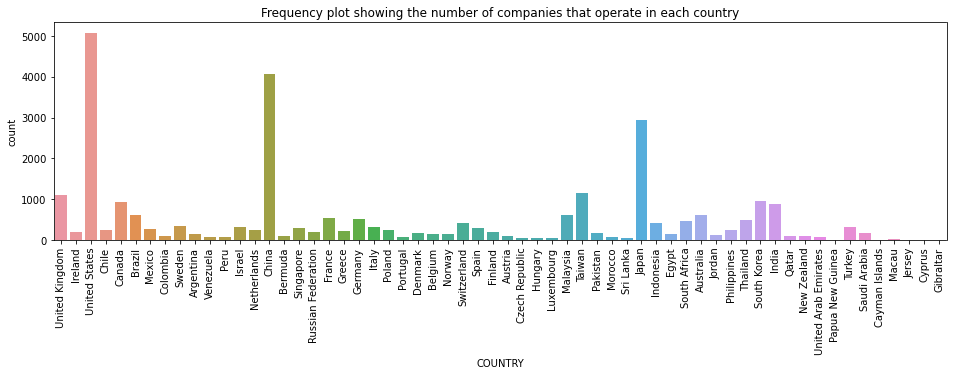

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
sns.countplot(data=X, x='COUNTRY', ax=ax)
ax.set_title("Frequency plot showing the number of companies that operate in each country")

# rotate the country names in the x-axis by 90 degrees
for tick in ax.get_xticklabels():
        tick.set_rotation(90) 

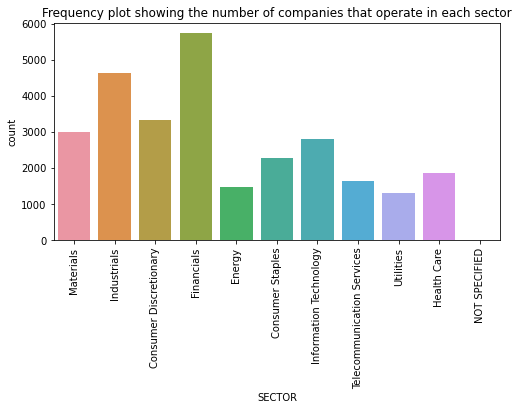

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.countplot(data=X, x='SECTOR', ax=ax)
ax.set_title("Frequency plot showing the number of companies that operate in each sector")

# rotate the sector names in the x-axis by 90 degrees
for tick in ax.get_xticklabels():
        tick.set_rotation(90) 

## 2. One-hot encoding

- One-hot encoding is a simple way that we can convert non-numeric data into a numeric form. 
- Let us take the ```SECTORS``` column as an example. 
- ... If we were to one-hot encode this column then we would split this column into 11 seperate columns. Each of the columns represent one of the 11 sectors. For each company we put a 1 in the column that corresponds to the sector that company belongs to and a 0 in the rest on the columns. We can do this easily in pandas by using the ```pd.get_dummies()``` function.

In [9]:
pd.get_dummies(X_unique['SECTOR']).head()

,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,NOT SPECIFIED,Telecommunication Services,Utilities
NAME,,,,,,,,,,,
Antofagasta plc,0,0,0,0,0,0,0,1,0,0,0
Ashtead Group plc,0,0,0,0,0,1,0,0,0,0,0
Barratt Developments PLC,1,0,0,0,0,0,0,0,0,0,0
Bellway p.l.c.,1,0,0,0,0,0,0,0,0,0,0
Balfour Beatty plc,0,0,0,0,0,1,0,0,0,0,0


Let us one-hot encode the ```SECTOR``` and ```COUNTRY``` columns.

In [10]:
ohe = pd.concat([
    pd.get_dummies(X['SECTOR']),
    pd.get_dummies(X['COUNTRY'])
], axis=1)
ohe.head()

,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,NOT SPECIFIED,Telecommunication Services,...,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Venezuela
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


One-hot encoding these columns will result in 71 new columns. These columns are high dimensional and very sparse (only two non-zero values per row). High dimensional sparse data can be difficult for a lot of machine learning models to deal with. Therefore it is normally a good idea to try and reduce the dimensions of one-hot encoded data. In this notebook we will use PCA and autoencoders to do just that. Let us start with PCA.

## 3. PCA

- Principle component analysis (PCA) is a method of reducing the dimensions of the data. 
- This is done by projecting the data onto principle components that point in the direction of most variance. 

What does this mean? In this section, we will try and get an intuitive idea behind what PCA is by looking at a simple two-dimensioal example. We start by generating some two-dimensional data that we can reduce the dimensions of.

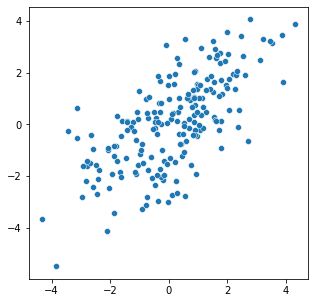

In [11]:
# generate some data
n = 200
D = np.random.multivariate_normal(
    mean = [0, 0], 
    cov = [[3, 2], [2,3]], # covariance matrix
    size = (n))
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(x=D[:,0], y=D[:,1], ax=ax);

Let us use PCA to generate the two principle components in the data.

In [12]:
from sklearn.decomposition import PCA

# fit two principle components in the data
pca = PCA(n_components = 2)
pca.fit(D)

# extract the principle components
pc1 = pca.components_[:, 0]
pc2 = pca.components_[:, 1]
print("The first principle compenent is:  ", pc1)
print("The second principle compenent is: ", pc2)

The first principle compenent is:   [-0.66080198 -0.75056029]
The second principle compenent is:  [-0.75056029  0.66080198]


The principle components ```pc1```, and ```pc2``` are vectors and thus have a direction. Let us see what direction the principle components point. 

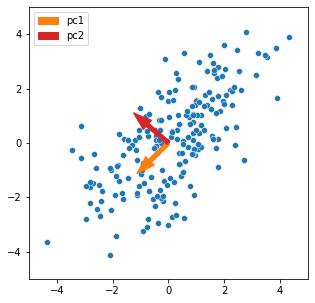

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(x = D[:, 0], y = D[:, 1])

# draw an arrow for pc1
ax.arrow(x = 0, y = 0, dx = pc1[0], dy = pc1[0], 
          color='tab:orange', width = 0.15, label='pc1')

# draw an arrow for pc2
ax.arrow(x = 0, y = 0, dx = pc2[0], dy =pc2[1], 
          color='tab:red', width = 0.15, label='pc2')

# we set the limits for x and y axis to be the same so our perspective is not warped
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax.legend();

The first principle component, ```pc1```, points in the direction of most variance. The second principle component. ```pc2```, is orthogonal to ```pc1``` and points in the direction of least variance. In fact scikit-learn orders the principle components in descending order of variance. So the first principle component always points in the direction of most variance.

What can we use these principle components for? We can project our data onto a subset of the principle components to get a lower dimensional representation of the data. In this example we project the data onto one of these principle componenents to get a one-dimensional representation of the data. We can project our data onto a principal component (or any vector for that matter) simply by finding the dot product of the data and the principle component. 

The figure below should help the reader visualise what is going on when we project our data onto a principle component. In the left figure, the olive lines show where each data point ends up on ```pc1``` after projection. The figure on the right shows the distribution on the data points after they have been projected onto ```pc1```.

No handles with labels found to put in legend.


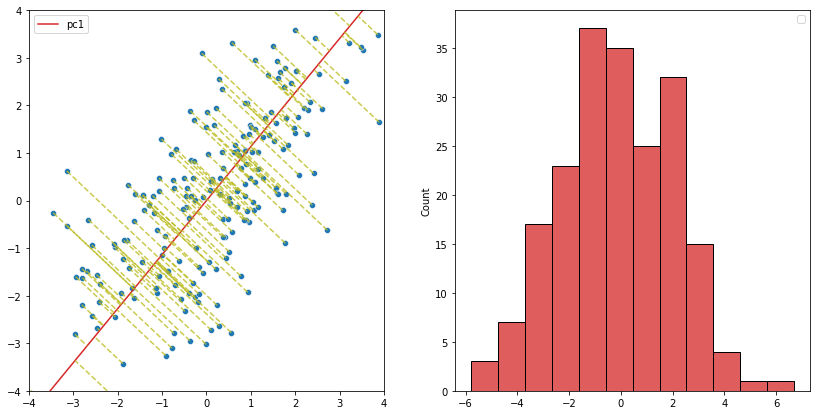

In [14]:
proj1 = D @ pc1 # project the data onto pc1
dists = np.array([proj1[i] * pc1 for i in range(n)])

fig, ax = plt.subplots(1,2,figsize=(14,7))

sns.scatterplot(x=D[:,0], y=D[:,1], ax=ax[0])
sns.lineplot(x=dists[:,0], y=dists[:,1], ax=ax[0], color='tab:red', label='pc1')

for i in range(n):
    ax[0].plot(
        [D[i, 0], dists[i, 0]], 
        [D[i, 1], dists[i, 1]], 
        color="tab:olive", alpha=0.8, linestyle='--'
    )
plt.legend();

# plot a histogram to show the distribution of datapoints after they have been projected onto pc1
sns.histplot(proj1, color='tab:red')

# we set the limits for the x and y axis to be the same to avoid getting a warped perspective
ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4,4);

Let us now see how the distributions differ when we project the data onto ```pc1``` and onto ```pc2```.

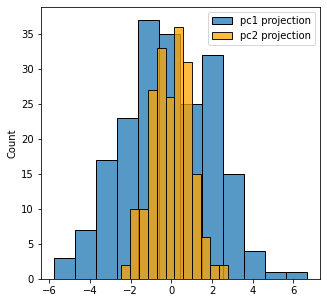

In [15]:
proj1 = D @ pc1
proj2 = D @ pc2

fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.histplot(proj1, ax=ax, label='pc1 projection')
sns.histplot(proj2, ax=ax, color='orange', label='pc2 projection')
ax.legend();

### Using PCA to reduce the dimensions of our one-hot encoded features

- Recall that our one-hot encoded features have 71 columns. 
- We now try to reduce this dimensionality. 
- We will do this by splitting the data into a training and test set. 
- We use the training set to find the principle components that we will use to reduce the dimensions of the one-hot encoded features in the training and test sets. 
- We then train an ordinary least squares regression (OLS) model on the training set and see how it performs on the test set.

In [18]:
from sklearn.model_selection import train_test_split

y = X['AVERAGE RETURN']

# drop the unwanted columns
X_ = X.drop(['NAME', 'TICKER', 'COUNTRY', 'SECTOR', 'YEAR', 'AVERAGE RETURN'], axis=1)

# split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.33, random_state=42)

# split the one-hot encoded features into a training and a test set
ohe_train = ohe.loc[X_train.index]
ohe_test = ohe.loc[X_test.index]

Now we use PCA to reduce the dimensions of the one-hot encoded features and see how the OLS models perform using different numbers of dimensions.

In [40]:
# **************************************
# **************************************
# LONG PROCESSING TIME!!
# **************************************
# **************************************

from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error

best_i = 0
best_j = 0
pca_best_loss_train = np.inf
pca_best_loss_test = np.inf

loss_hist = pd.DataFrame(columns=['num_components', 'loss'])
for i in range(1, ohe.shape[1]):
    pca = PCA(n_components=i)
    pca.fit(ohe_train)

    # reduce the dimension of the one-hot encoded training data
    ohe_train_reduced = pca.transform(ohe_train)
    ohe_test_reduced = pca.transform(ohe_test)
    
    # append the reduced one hot enoded feeatures to X_train and X_test
    X_train_reduced = np.hstack((X_train, ohe_train_reduced))
    X_test_reduced = np.hstack((X_test, ohe_test_reduced))

    ols_model = OLS(y_train, X_train_reduced)
    res = ols_model.fit()

    loss_train = mean_squared_error(res.predict(X_train_reduced), y_train)
    loss_test = mean_squared_error(res.predict(X_test_reduced), y_test)
    loss_hist.loc[loss_hist.shape[0] + 1] = [i, loss]

    if loss_train < pca_best_loss_train:
        pca_best_loss_train = loss_train
        pca_best_loss_test = loss_test
        best_i = i
    print("i = %i   loss = %f" % (i, loss_test))
print("best_i = %i   pca_best_loss_train = %f   pca_best_loss_test = %f" % (best_i, pca_best_loss_train, pca_best_loss_test))

i = 1   loss = 0.684040
i = 2   loss = 0.635837
i = 3   loss = 0.625266
i = 4   loss = 0.678651
i = 5   loss = 0.676416
i = 6   loss = 0.695009
i = 7   loss = 0.681137
i = 8   loss = 0.722067
i = 9   loss = 0.721416
i = 10   loss = 0.730511
i = 11   loss = 0.703613
i = 12   loss = 0.703697
i = 13   loss = 0.698999
i = 14   loss = 0.709444
i = 15   loss = 0.714899
i = 16   loss = 0.711879
i = 17   loss = 0.725088
i = 18   loss = 0.723561
i = 19   loss = 0.714292
i = 20   loss = 0.721553
i = 21   loss = 0.715090
i = 22   loss = 0.724098
i = 23   loss = 0.729632
i = 24   loss = 0.723433
i = 25   loss = 0.721028
i = 26   loss = 0.688986
i = 27   loss = 0.651590
i = 28   loss = 0.567471
i = 29   loss = 0.532386
i = 30   loss = 0.531315
i = 31   loss = 0.513786
i = 32   loss = 0.527797
i = 33   loss = 0.531763
i = 34   loss = 0.527683
i = 35   loss = 0.552513
i = 36   loss = 0.529219
i = 37   loss = 0.515843
i = 38   loss = 0.391323
i = 39   loss = 0.392779
i = 40   loss = 0.369911
i = 41   

<AxesSubplot:xlabel='num_components', ylabel='loss'>

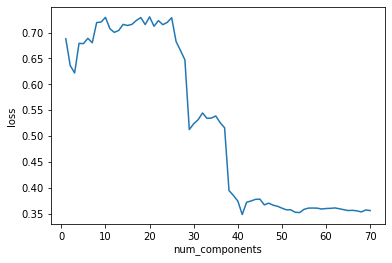

In [20]:
sns.lineplot(data=loss_hist, y='loss', x='num_components')

The OLS model performed best when we reduced the dimensions of the one-hot encoded features to 41. Let us now look at using an autoencoder to reduce the dimensions of data. 

# 4. Autoencoders

- Auto encoders take a deep learning approach to reducing the dimensions of data. 
- An autoencoder is made up of two distinct parts: an encoder, and a decoder. The image below shows a very simple autoencoder.
- The units in the middle generate a latent representation of the dataset - a distilled version of the data
- IJn the graphic we reduce a data set of 8 dimensions to 4. 
- We now wrap the Pytorch autoencoder functions in a class...

![autoencoder](images/autoencoder.png)

The encoder has 8 input units, 0 hidden units, and 4 output units. The decoder has 4 input units, 0 hidden units and 8 output units. The output of the encoder is used as the input of the decoder. Let us suppose we have some 8-dimensional input $x$. To pass $x$ through the autoencoder, we first pass it through the encoder and then pass the output of the encoder through the decoder. So the encoder reduces the dimensons of the input from 8 to 4, and then the decoder increases the dimensions from 4 to 8. Perhaps the strangest thing about autoencoders is that for an input $x$ the target of the autoencoder is also $x$. In other words the goal of the encoader during training is to find an efficient low dimensional representation of $x$, and the goal of the decoder is to take that low dimensional representation and reconstruct the original input $x$.

Our one-hot encoded features have 71 dimensions. So, we will create an autoencoder in Pytorch such that the encoder has 71 input units, 45 hidden units and 30 output units. The decoder will have 30 input units, 45 hidden units and 71 output units. Let us begin.

In [23]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(71, 45), # 11 input nodes 4 output nodes
            nn.ReLU(),
            nn.Linear(45, 15), # 45 input nodes 30 output nodes
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(15, 45), # 30 input units and 45 output units
            nn.ReLU(),
            nn.Linear(45, 71), # 45 input units and 71 output units
            nn.Tanh()
        )
        
    def forward(self, x):
        # pass an input through the entire autoencoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    def encode(self, x):
        # encode some input x
        return self.encoder(x)

Now that we have defined our model we need to define a training loop for our model. To make things a little more clear, let us run through the fundamental components of a training loop in Pytorch:

1. Epochs. Training a neural can be broken down into epochs. An epoch is defined as a cycle through the entire training data. Since neural networks usually contain lots (tens of millions in some cases) of parameters, we have train them slowly using a very small learning rate. We therefore have to pass the training data through the network multiple times to give the network chance to learn the data. 

2. Loss function. A loss function is what we use to determine how well our model is performing. In our autoencoder we will use mean squared error which can be called in Pytorch using the ```torch.nn.MSELoss``` function. Pytorch also uses this loss function to calculate gradients that are used to update the parameters of the model.

3. Optimizer. An optimizer in Pytorch lets us define how we want the parameters in our model to be updated. In our autoencoder we will use stochastic gradient descent which can be called using the ```torch.optim.SGD()``` function. 

4. Batch loader. A batch loader lets us split the training data into mini-batches. This lets us pass data into the neural network in small batches as opposed to passing the entire training data into to the network in one go (batch gradient descent) or passing each training sample into network seperately. Using mini-batches can help speed up the training of the model, and improve how well it generalises. [This](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data) stack exchange thread has a great discussion on why one might use mini-batches. In Pytorch, we can create a batch loader by calling the ```torch.utils.data import DataLoader```.

5. Calculating the training and test loss. After each epoch it is usually a good idea to see how the model performs on the entire training set and the test set. However there is a small hurdle we have to be aware doing this in Pytorch. Pytorch uses a very clever technique called [auto-differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) to automatically calculate the gradients used to update the weights in a model. This is computationally expensive and is not needed during testing since we do not want to update the parameters of the model during testing. We can briefly turn off Pytorch's auto-differentiation engine by using ```with torch.no_grad():``` which turns off auto-differentiation for any code in that block. This allows us to quickly test the performance of the model without performing any expensive auto-differentiation.

Now let us write our training loop.

In [24]:
# **************************************
# **************************************
# LONG PROCESSING TIME!!
# **************************************
# **************************************

from torch.utils.data import DataLoader

autoencoder = Autoencoder()

# covert the training and test data into pytorch tensors
ohe_train_tensor = torch.from_numpy(ohe_train.values).float()
ohe_test_tensor = torch.from_numpy(ohe_test.values).float()

nepochs=100 # number of epochs we train the model for

optimizer = torch.optim.SGD(autoencoder.parameters(), lr=0.001)

loss_fn = torch.nn.MSELoss()

dataloader = DataLoader(dataset=ohe_train_tensor, batch_size=10, shuffle=True)

loss_train_hist = []
loss_test_hist = []

for epoch in range(nepochs):
    for ohe_train_tensor_batch in dataloader:
        # set the gradients to zero from the previous batch
        optimizer.zero_grad() 
        
        y_hat = autoencoder(ohe_train_tensor_batch) 
        
        loss_train = loss_fn(y_hat, ohe_train_tensor_batch) # batch error
        
        # backpropagate through the network to get the gradients needed to update the parameters in the model
        loss_train.backward() 
        
        # update the model paramters 
        optimizer.step()
    
    with torch.no_grad():
        # calculate the training error
        y_hat = autoencoder(ohe_train_tensor)
        loss_train = loss_fn(y_hat, ohe_train_tensor)
        
        # calculate the test error
        y_hat = autoencoder(ohe_test_tensor)
        loss_test = loss_fn(y_hat, ohe_test_tensor)
        
        
        loss_train_hist.append(loss_train)
        loss_test_hist.append(loss_test)
        if (epoch % 10 == 0):
            print("Epoch %i  training error %f  test error %f" % (epoch, loss_train.item(), loss_test.item()))

Epoch 0  training error 0.038119  test error 0.038183
Epoch 10  training error 0.027926  test error 0.027931
Epoch 20  training error 0.025906  test error 0.025887
Epoch 30  training error 0.025427  test error 0.025397
Epoch 40  training error 0.025300  test error 0.025264
Epoch 50  training error 0.025254  test error 0.025215
Epoch 60  training error 0.025227  test error 0.025187
Epoch 70  training error 0.025203  test error 0.025161
Epoch 80  training error 0.025179  test error 0.025137
Epoch 90  training error 0.025154  test error 0.025112


Let us plot ```loss_train_hist```, and ```loss_test_hist```.

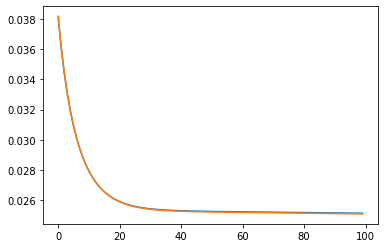

In [26]:
plt.plot(loss_train_hist)
plt.plot(loss_test_hist)

Now let us see how our OLS model performs when we use the autoencoders to reduce the dimensions of the data.

In [27]:
with torch.no_grad():
    X_train_reduced = np.hstack((
        X_train,
        autoencoder.encode(ohe_train_tensor)
    ))

    X_test_reduced = np.hstack((
        X_test,
        autoencoder.encode(ohe_test_tensor)
    ))

## 5. Autoencoder, PCA, full data-set Shoot out...

Now we compare the MSE based on an OLS using input data dimensionality reduced by 

1) Autoencoders

2) PCA

3) ... the full unadulterated dataset.

Let's get the losses for each.... First the autoencoder..... we pass in the latent representation ```X_train_reduced``` into the OLS learner....

In [41]:
#Train OLS using the latent representation created by the autoencoder
ols_model = OLS(y_train, X_train_reduced)
res = ols_model.fit()

ae_train_loss = mean_squared_error(res.predict(X_train_reduced), y_train)
ae_test_loss = mean_squared_error(res.predict(X_test_reduced), y_test)

print("Training loss:", ae_train_loss)
print("Test loss:", ae_test_loss)

Training loss: 0.1435619276226356
Test loss: 0.35614951297623076


We already have the PCA test loss from earlier... Now we pass in the unaltered data into the OLS learner.... no dimensionality reduction ....

In [42]:
#Train OLS using FULL DATASET
ols_model = OLS(y_train, X_train)
res = ols_model.fit()

train_loss_full_ds = mean_squared_error(res.predict(X_train), y_train)
test_loss_full_ds = mean_squared_error(res.predict(X_test), y_test)

print("Training loss:", train_loss)
print("Test loss:", test_loss)

Training loss: 0.14491358512790972
Test loss: 0.45872072269584685


In [48]:
#Shoot out....
if ae_train_loss == min(pca_best_loss_test, ae_train_loss, test_loss_full_ds):
    print('Autoencoders win! Non-linear dimensionality reduction is the way to go...')

elif pca_best_loss_test == min(pca_best_loss_test, ae_train_loss, test_loss_full_ds):
    print('PCA wins! Linearity is fab... but perhaps we should try the same degree of parameter tuning on the auto encoder as we put in place for PCA!')

elif test_loss_full_ds == min(pca_best_loss_test,ae_train_loss, test_loss_full_ds):
    print('Honestly. Dont bother... Full dataset wins....')

Autoencoders win! Non-linear dimensionality reduction is the way to go...
